In [ ]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [2]:
import kaggle

dataset_name = 'phylake1337/fire-dataset'
download_path = './data'

In [3]:
# 데이터가 없을 때만 다운로드 (중복 방지)

if not os.path.exists(download_path):
    try:
        kaggle.api.dataset_download_files(dataset_name, path=download_path, unzip=True)
        print("다운로드 완료")
    except Exception as e:
        print(f"다운로드 실패: {e}")
else:
    print("다운로드 스킵")

# 실제 폴더 구조 확인
target_root = None
for root, dirs, files in os.walk(download_path):
    level = root.replace(download_path, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f"{indent}{os.path.basename(root)}/")
    
    # 'fire_images'라는 폴더가 보이면 그 상위 폴더를 데이터셋 루트로 잡음
    if 'fire_images' in dirs:
        target_root = root

print(target_root)

다운로드 스킵
data/
    fire_dataset/
        non_fire_images/
        fire_images/
./data/fire_dataset


In [12]:
from collections import Counter

# 이미지 전처리 (224 * 224로 조정)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ImageFolder로 불러오기
if target_root:
    dataset = datasets.ImageFolder(root=target_root, transform=transform)
    
    # DataLoader 생성
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # 클래스별 데이터셋 개수 출력
    class_indices_counts = Counter(dataset.targets)
    
    for idx, count in sorted(class_indices_counts.items()):
        class_name = dataset.classes[idx]
        print(f"- {class_name}: {count}")

- fire_images: 755
- non_fire_images: 244


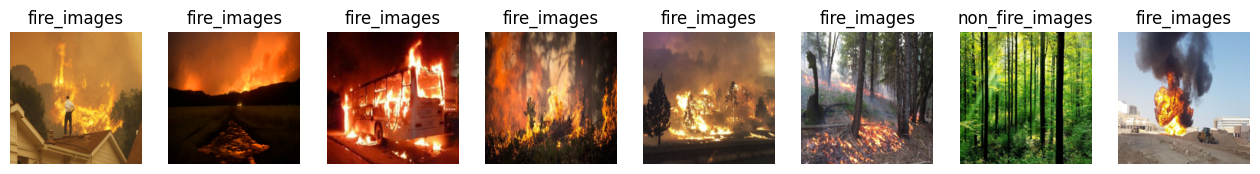

In [10]:
# 데이터셋 확인

images, labels = next(iter(dataloader))
plt.figure(figsize=(16, 6))

# 8장 출력
for i in range(8):
    ax = plt.subplot(1, 8, i + 1)
    img = images[i].permute(1, 2, 0)
        
    plt.imshow(img)
    plt.title(dataset.classes[labels[i]])
    plt.axis('off')
plt.show()

In [17]:
# GPU 자랑 타임

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
1
0
NVIDIA GeForce RTX 4060 Ti
